In [18]:
%matplotlib widget

import os
import pickle
import shutil 
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math
from IPython import embed

In [25]:
## initialize matrix for data collection ##

num_holes = 15 # this is the number of holes we will build
data = np.zeros((3,num_holes))

# set up simulation constants

resolution = 20

n_air = 1.0000003
n_SiO2 = 1.45
n_Si = 3.48

a = 0.5   # lattice period 

pml_thickness = 0.780
Si = 0.5       # eventually we're going to vary this value so the following values will change dynamically
SiO2 = 0.25 * Si         # so the height of Si02 (high index material embedded in Si) is always 25percent of Si
air_buffer = 0.4 * SiO2          # and the air buffer is 40 percent of SiO2
air_block = pml_thickness*2 + Si + air_buffer*2   # this is the length of the material plus pml and a 0.5 micron air buffer above and below the material
air_hole = air_block

cell_x = a
cell_y = a
cell_z = air_block

center_Si = 0
center_air = 0
center_SiO2 = 0.5*SiO2

k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## set up and build source ##

center_source = -0.5*Si - 0.4*air_buffer
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]

#### Set up simulation ####

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

#### set up symmetries ####

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]

##### build geometry ########

geometry=[mp.Block(size=mp.Vector3(mp.inf,mp.inf,air_block),
                    center=mp.Vector3(0,0,center_air),
                    material=mp.Medium(index=n_air))]

In [26]:
sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

## set up and build flux monitor ##
####################################

nfreq = 1
df = 0
fr_center = 0.5*Si + 0.4*air_buffer
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)

sim.run(until=200)

initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00221086 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 2.15 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,2.16)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0214801 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


98.48481056449205
     block, center = (0,0,0)
          size (1e+20,1e+20,2.16)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


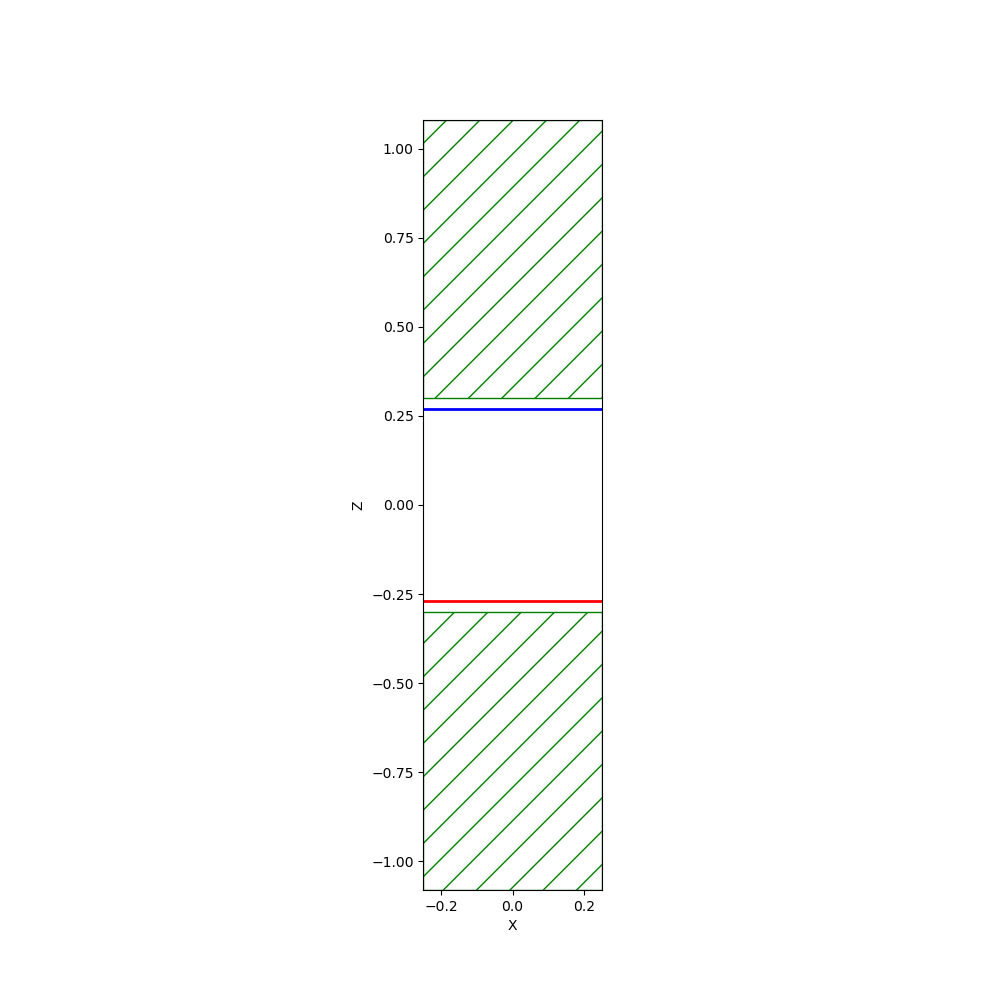

In [27]:
print(initial_flux)
fig = plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)

In [ ]:
sim.reset_meep()

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,Si), 
                   center=mp.Vector3(0,0,center_Si),
                   material=mp.Medium(index=n_Si)))

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,SiO2),
                    center=mp.Vector3(0,0,center_SiO2),
                    material=mp.Medium(index=n_SiO2)))

pbar = tqdm(total=num_holes,leave=False)
min = 0.0
max = 0.240
for i,radius in enumerate(np.linspace(min,max,num=num_holes)):
    geometry.append(mp.Cylinder(radius=radius,
                        height=cell_z,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,0),
                        material=mp.Medium(index=n_air)))

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  

    sim.run(until=200)
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    
    if(radius!=max):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()

In [11]:
import pickle
data = pickle.load(open("data.pkl", "rb"))
initial_flux = pickle.load(open("initial_flux.pkl","rb"))

In [12]:
initial_flux

93.15895585406514

/tmp/ipykernel_2210/3929324357.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


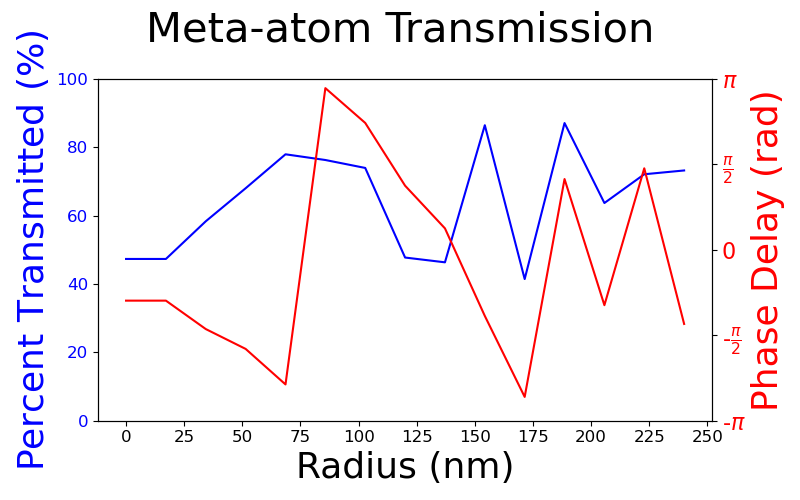

In [13]:
plt.close("all")

radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

plt.style.use('seaborn-colorblind')

tickfontsize=12
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0,0.025,0.05,0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([0,25,50,75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

twin1 = ax.twinx()
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')

plt.grid(False)
plt.tight_layout()

In [ ]:
flux_list

In [ ]:
data[1,0:]